In [1]:
#import all relevant packages

import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder as le
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from statsmodels.tools.tools import add_constant
from google.colab import files
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [2]:
#import and read the dataset
#os.chdir("/clean_BNPL_clients.csv")

bnpl = pd.read_csv('clean_BNPL_python.csv')

#define a function to convert category features into numerical

def encode_categoricals(df, categorical_features):
  for col in categorical_features:
    df[col] = df[col].astype("category").cat.codes
  return df

#identify the numerical categories

bnpl_continuous = bnpl[['loan_amnt', 'int_rate', 'monthly_payment', 'annual_inc', 'total_dti', 'tot_coll_amt', 'tot_cur_bal', \
                                  'total_bal_ex_mort','credit_limit']]

#identify categorical categories

bnpl_categor = bnpl[['loan_term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_purpose', \
                               'delinq_2yrs', 'open_acc','addr_state', 'application_type', 'cur_acct_delinq', 'mort_acc', \
                               'num_accts_120_pd', 'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag', 'disbursement_method', \
                               'debt_settlement_flag']]
#source the column indices
bnpl_categor_indx = [bnpl.columns.get_loc(col) for col in bnpl_categor]

#use the encoding function to convert the string variables into numerical

bnpl_num = encode_categoricals(bnpl, bnpl_categor)

#enact one-hot encoding
bnpl_num = pd.get_dummies(bnpl_num, columns=bnpl_categor.columns,
                          prefix = bnpl_categor.columns)

#split the data into training and test sets

bnpl_att = bnpl_num.drop(['loan_status'], axis=1)
bnpl_tar = bnpl_num['loan_status']

from sklearn.model_selection import train_test_split

bnpl_att_train, bnpl_att_test, bnpl_tar_train, bnpl_tar_test = train_test_split(bnpl_att, bnpl_tar, test_size=0.3, random_state=55)

#resample the data with SMOTE, which will go on to be used in the models

from imblearn.over_sampling import SMOTE
bnpl_smote = SMOTE(random_state=1000)

bnpl_train_att_resample, bnpl_train_tar_resample = bnpl_smote.fit_resample(bnpl_att_train, bnpl_tar_train)

#resample the data with k-means SMOTE methods

from imblearn.over_sampling import KMeansSMOTE
bnpl_KMsmote = KMeansSMOTE(random_state=1000, cluster_balance_threshold=0.1, kmeans_estimator=30)

bnpl_train_att_KM_resample, bnpl_train_tar_KM_resample = bnpl_KMsmote.fit_resample(bnpl_att_train, bnpl_tar_train)

In [3]:
#define a function to quickly create hidden layers of a NN

def create_hidden_layer(df, neural_network, max_layer, divisor=2):
  """
  a function to quickly program iterative hidden layers
  includes first hidden layer which takes into account number of input neurons
  interates backwards from max number of layers, going down by dividing by divisor
  df: pandas dataframe
  neural_network: the NN being constructed
  may_layer: the most layers you want, should be even number
  increment: number to divide by
  """
  num = max_layer
  i = 0
  while num >= 3:
    unit = int(num)
    if i == 0:
       hidden_layer_num = Dense(units=unit, activation="relu", input_shape=(df.shape[1],))
    else:
       hidden_layer_num = Dense(units=unit, activation="relu")
    neural_network.add(hidden_layer_num)
    num /= divisor
    i += 1


In [4]:
#develop the NN model

bnpl_nn = Sequential()

create_hidden_layer(bnpl_train_att_resample, bnpl_nn, 128)

output_layer = Dense(units=1, activation="sigmoid")
bnpl_nn.add(output_layer)

bnpl_nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        35,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,753 (182.63 KB)

 Trainable params: 46,753 (182.63 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#scale the data for accuracy test, pre-training
scaler = MinMaxScaler()
bnpl_test_att_scaled = scaler.fit_transform(bnpl_att_test)

In [6]:
#encode the y_test data to labeled categorical for neural network accuracy_score functionality
y_test_encoded = le().fit_transform(bnpl_tar_test)

#because the neural network outputs probabilities, convert the output values back into binary
tar_pred_probs = bnpl_nn.predict(bnpl_test_att_scaled)
tar_pred = (tar_pred_probs > 0.5).astype(int).flatten()

#test the accuracy of the neural network without training
accuracy_score(y_test_encoded, tar_pred)

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.36752088507563785

In [8]:
#compile the network to get it ready for training
bnpl_nn.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer = 'rmsprop')

In [9]:
#incase we want to reset the weight, we'll save them into this variable for future use
initial_weights = bnpl_nn.get_weights()

In [10]:
#we'll enact a callback with an early_stop since running many epochs is high computational time
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

In [11]:
#encode the y_train variable
y_train_encoded = le().fit_transform(bnpl_train_tar_resample)

In [12]:
#train the data with x_train SMOTE resample
bnpl_nn.fit(bnpl_train_att_resample, y_train_encoded, epochs=50, batch_size = 32, callbacks=early_stop)

Epoch 1/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4992 - loss: 2.2150
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


2378/2378 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5008 - loss: 0.6931
Epoch 3/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5007 - loss: 0.6931
Epoch 4/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.4976 - loss: 0.6932
Epoch 5/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5046 - loss: 0.6931
Epoch 6/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.4994 - loss: 0.6932
Epoch 7/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4979 - loss: 0.6932
Epoch 8/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4997 - loss: 0.6932
Epoch 9/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5007 - loss: 0.6932
Epoch 10/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4974 - loss: 0.6932
Epoch 11/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5008 - loss: 0.6932
Epoch 12/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5014 - loss: 0.6932
Epoch 13/50
2378/2378 ━━━━━━━━━━━━

In [13]:
#check the accuracy after training
score = bnpl_nn.evaluate(bnpl_att_test, y_test_encoded)
print('Training accuracy: {}%'.format(score[1]*100))

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9192 - loss: 0.6881
Training accuracy: 92.16527342796326%


554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


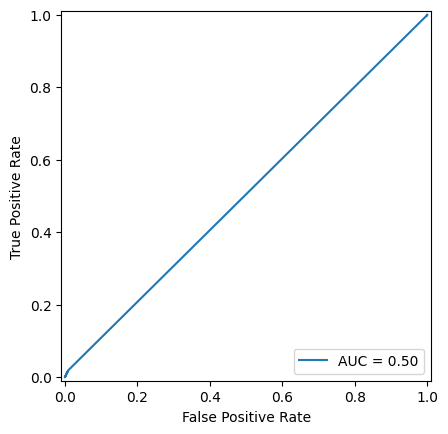

In [17]:
#calculate area under the curve
fpr, tpr, threshold = roc_curve(bnpl_tar_test, ((bnpl_nn.predict(bnpl_test_att_scaled))).flatten(), pos_label='solvent')

bnpl_nn_roc_auc = auc(fpr, tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=bnpl_nn_roc_auc)
display.plot()

# Repeat with Kmeans SMOTE resampling

In [18]:
#develop the NN model with kMEans Smote

bnpl_nn_km = Sequential()

create_hidden_layer(bnpl_train_att_KM_resample, bnpl_nn_km, 128)

output_layer = Dense(units=1, activation="sigmoid")
bnpl_nn.add(output_layer)

bnpl_nn_km.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │        35,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,748 (182.61 KB)

 Trainable params: 46,748 (182.61 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#convert the output values back into binary
km_tar_pred_probs = bnpl_nn_km.predict(bnpl_test_att_scaled)
km_tar_pred = (km_tar_pred_probs[:,1] > 0.5).astype(int).flatten()

#test the accuracy of the neural network without training
accuracy_score(y_test_encoded, km_tar_pred)

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.07834725671709189

In [20]:
#compile the network to get it ready for training
bnpl_nn_km.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer = 'rmsprop')

#save the initial weights for preserverance
km_initial_weights = bnpl_nn_km.get_weights()

In [21]:
#encode the y_train variable
km_y_train_encoded = le().fit_transform(bnpl_train_tar_KM_resample)

#train the data with x_train KMSMOTE resample
bnpl_nn.fit(bnpl_train_att_KM_resample, km_y_train_encoded, epochs=50, batch_size = 32, callbacks=early_stop)

Epoch 1/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5010 - loss: 0.6932
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


2378/2378 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.5000 - loss: 0.6932
Epoch 3/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4959 - loss: 0.6932
Epoch 4/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5007 - loss: 0.6932
Epoch 5/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5012 - loss: 0.6932
Epoch 6/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5004 - loss: 0.6932
Epoch 7/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5002 - loss: 0.6932
Epoch 8/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5032 - loss: 0.6931
Epoch 9/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.4966 - loss: 0.6932
Epoch 10/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5031 - loss: 0.6932
Epoch 11/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5022 - loss: 0.6931
Epoch 12/50
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5006 - loss: 0.6931
Epoch 13/50
2378/2378 ━━━━━━━━━━━━━━━━

In [22]:
#check the accuracy after training
y_test_encoded = le().fit_transform(bnpl_tar_test)
y_test_encoded = to_categorical(y_test_encoded, num_classes=2)

score = bnpl_nn_km.evaluate(bnpl_att_test, y_test_encoded)
print('Training accuracy: {}%'.format(score[1]*100))

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 4)

In [ ]:
#calculate area under the curve
fpr, tpr, threshold = roc_curve(bnpl_tar_test, (bnpl_nn_KM.predict_proba(bnpl_test_att_scaled)[:, 1]), pos_label='solvent')

bnpl_nn_roc_auc = auc(fpr, tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=bnpl_nn_roc_auc)
display.plot()